Resources:

- https://docs.pytorch.org/docs/stable/generated/torch.nn.LSTM.html
- https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/




#### Dependencies

In [213]:
import os
import re
import json
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import spearmanr, pearsonr
from pathlib import Path
import numpy as np
import random
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from datetime import datetime, timedelta
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import SMAIndicator, MACD, CCIIndicator
from ta.momentum import WilliamsRIndicator
from ta.volume import ChaikinMoneyFlowIndicator



In [112]:
print(torch.__version__)
print(torch.version.cuda) 
print(torch.cuda.is_available())   # True if a GPU is detected
print(torch.cuda.device_count())   # Number of GPUs available
# print(torch.cuda.get_device_name(0))  # Name of the first GPU

2.9.0+cu128
12.8
True
1


#### Useful functions

In [176]:
def load_data(
    ticker: str,
    start_date: str,
    end_date: str,
    leadup_days: int = 30,
    interval: str = "1d",
    
):
    """
    Fetches price data with extra leadup_days for indicator warmup,
    computes technical indicators, and trims back to the exact start_date.
    """

    # Compute leadup start date
    start_dt = datetime.strptime(start_date, "%Y-%m-%d")
    leadup_start_dt = start_dt - timedelta(days=leadup_days)
    leadup_start = leadup_start_dt.strftime("%Y-%m-%d")

    # Fetch data
    ticker_obj = yf.Ticker(ticker)
    df = ticker_obj.history(
        start=leadup_start,
        end=end_date,
        interval=interval,
        auto_adjust=False,
        actions=False
    )
    
    # Ensure columns are consistent
    df = df.copy()
    df.index = df.index.normalize()
    df.columns = df.columns.str.lower().str.replace(" ", "_")
    
    return df

    

In [ ]:
def add_indicators(df: pd.DataFrame, 
    # pred_target: int,
    # start_date: str,
    sma_vals=[10, 20]
    ):
    # Ensure columns are consistent
    df = df.copy()
    df.index = df.index.normalize()
    df.columns = df.columns.str.lower().str.replace(" ", "_")

    # === Add Indicators ===
    # SMA
    for i in sma_vals:
        df[f"sma_{i}"] = SMAIndicator(df["close"], window=i).sma_indicator()

    # Stochastic Oscillator
    stoch = StochasticOscillator(
        df["high"], df["low"], df["close"],
        window=14, smooth_window=3
    )
    df["stoch_k"] = stoch.stoch()
    df["stoch_d"] = stoch.stoch_signal()

    # MACD
    macd = MACD(df["close"], window_slow=26, window_fast=12, window_sign=9)
    df["macd"] = macd.macd()
    df["macd_signal"] = macd.macd_signal()
    df["macd_hist"] = macd.macd_diff()

    # CCI
    df["cci"] = CCIIndicator(df["high"], df["low"], df["close"], window=20).cci()

    # Williams %R
    df["williams_r"] = WilliamsRIndicator(df["high"], df["low"], df["close"], lbp=14).williams_r()

    # RSI
    df["rsi"] = RSIIndicator(df["close"], window=14).rsi()

    # ADOSC (Chaikin Money Flow)
    df["adosc"] = ChaikinMoneyFlowIndicator(
        high=df["high"],
        low=df["low"],
        close=df["close"],
        volume=df["volume"],
        window=20
    ).chaikin_money_flow()
    
    # # Log-return Prediction Target
    # daily_log_return = np.log(df["close"] / df["close"].shift(1))
    # df[f"{pred_target}_day_target"] = (
    #     daily_log_return.rolling(pred_target).sum().shift(-pred_target)
    # )

    # Drop NaNs caused by indicator warmup
    df = df.dropna()

    # Trim back to the actual start_date (remove leadup)
    # df = df[df.index >= (start_date)]

    return df

In [215]:
def generate_prediction_targets(df: pd.DataFrame, pred_targets: list) -> pd.DataFrame:
    """
    Adds multiple prediction horizon target columns to the dataframe using
    cumulative log returns.

    Example:
      pred_targets = [1, 5, 10, 15]
      → columns: ["1_day_target", "5_day_target", "10_day_target", "15_day_target"]
    """

    df = df.copy()

    # Compute daily log returns once
    daily_log_return = np.log(df["close"] / df["close"].shift(1))

    for t in pred_targets:
        df[f"{t}_day_target"] = (
            daily_log_return.rolling(t).sum().shift(-t)
        )

    # Drop NaNs only once (after all targets are added)
    df = df.dropna()

    return df

In [115]:
def make_sequences(df, target_col ,feature_cols, seq_len=10):
    X, y = [], []
    
    values = df[feature_cols].values
    targets = target_col.values

    for i in range(len(df) - seq_len):
        X.append(values[i:i+seq_len])
        y.append(targets[i+seq_len])

    return np.array(X), np.array(y)

In [116]:
def plot_and_save_metrics(metrics_df, target_horizon, save_table=True):
      """Creates and saves three metric plots:
         (1) RMSE + MAE together
         (2) Directional Accuracy
         (3) Spearman Correlation
         (4) Metrics table of all years
         Files are named using the prediction horizon.
      """
      
      # Create directory name and ensure it exists
      base_folder = "results"
      folder_name = os.path.join(base_folder, f"target_{target_horizon}")
      os.makedirs(folder_name, exist_ok=True)

      years = metrics_df["year"]

      # --- Plot 1: RMSE + MAE ---
      fig1, ax1 = plt.subplots(figsize=(8, 4))
      ax1.plot(years, metrics_df["rmse"], marker="o", label="RMSE")
      ax1.plot(years, metrics_df["mae"], marker="o", label="MAE")
      ax1.set_title(f"RMSE & MAE ({target_horizon}-Day Horizon)")
      ax1.set_xlabel("Year")
      ax1.set_ylabel("Error Value")
      ax1.grid(True, alpha=0.3)
      ax1.legend()
      
      filename1 = f"metrics_target_{target_horizon}_RMSE_MAE.png"
      fig1.tight_layout()
      fig1.savefig(os.path.join(folder_name, "RMSE_MAE.png"), dpi=150)
      plt.close(fig1)


      # --- Plot 2: Directional Accuracy ---
      
      fig2, ax2 = plt.subplots(figsize=(8, 4))
      ax2.plot(years, metrics_df["directional_accuracy (%)"], marker="s", linestyle="--")
      ax2.set_ylim(0, 100)
      ax2.set_title(f"Directional Accuracy ({target_horizon}-Day Horizon)")
      ax2.set_xlabel("Year")
      ax2.set_ylabel("Directional Accuracy (%)")
      ax2.grid(True, alpha=0.3)

      filename2 = f"metrics_target_{target_horizon}_Directional_Accuracy.png"
      fig2.tight_layout()
      fig2.savefig(os.path.join(folder_name, "Directional_Accuracy.png"), dpi=150)
      plt.close(fig2)


      # --- Plot 3: Spearman Correlation ---
      fig3, ax3 = plt.subplots(figsize=(8, 4))
      ax3.plot(years, metrics_df["spearman"], marker="s", linestyle=":")
      ax3.set_title(f"Spearman Correlation ({target_horizon}-Day Horizon)")
      ax3.set_xlabel("Year")
      ax3.set_ylabel("Spearman")
      ax3.grid(True, alpha=0.3)

      filename3 = f"metrics_target_{target_horizon}_Spearman.png"
      fig3.tight_layout()
      fig3.savefig(os.path.join(folder_name, "Spearman.png"), dpi=150)
      plt.close(fig3)
      
      
      # save the df for good measure
      df_file = f"metrics_target_{target_horizon}.csv"
      # optional table save 
      if save_table:
        metrics_df.to_csv(os.path.join(folder_name, "metrics.csv"), index=False)
      

      print("\nSaved plots:")
      print(f" - {filename1}")
      print(f" - {filename2}")
      print(f" - {filename3}")
      print(f" - {df_file}")


In [225]:
def collect_target_metrics():
    """
    Collects metrics.csv files from folders named result_target_[TARGET]
    and returns a combined dataframe sorted by TARGET value.
    """
    # Get the directory of the current script
    base_dir = Path.cwd()
    results_path = base_dir / "results"

    combined_results = []
    print("Folders found:", os.listdir(results_path))
    
    # Regex to detect folders like result_target_5, result_target_10, etc.
    folder_pattern = re.compile(r"target_(\d+)")
    for folder_name in os.listdir(results_path):
        
        match = folder_pattern.match(folder_name)
        if match:
            target_value = int(match.group(1))
            metrics_file = os.path.join(results_path, folder_name, "metrics.csv")
            # print(f"Checking: {metrics_file}")

            if os.path.exists(metrics_file):
                df = pd.read_csv(metrics_file)
                df["pred_target"] = target_value
                combined_results.append(df)
            else:
                print(f"WARNING: {metrics_file} not found.")

    # Combine all collected data
    if combined_results:
        final_df = pd.concat(combined_results, ignore_index=True)
        final_df = final_df.set_index(["year", "pred_target"]).sort_index()
        return final_df
    else:
        print("No metrics.csv files found.")
        return pd.DataFrame()

In [118]:
def generate_metrics(results):
    """
    Generate yearly prediction performance metrics from model results.

    Parameters
    ----------
    results : list[pd.DataFrame]
        A list of DataFrames where each contains:
        ['date', 'prediction', 'actual']

    Returns
    -------
    pd.DataFrame
        Metrics sorted by year containing:
        RMSE, MAE, Directional Accuracy (%), and Spearman Rank Correlation.
    """

    year_stats = []

    for df_year in results:  # each entry is a year dataframe

        year = df_year['date'].iloc[0].year  # extract year from first row's date

        preds = df_year["prediction"].values
        actual = df_year["actual"].values

        # Metrics
        rmse = np.sqrt(mean_squared_error(actual, preds))
        mae = mean_absolute_error(actual, preds)
        
        # directional accuracy
        direction_accuracy = (np.sign(preds) == np.sign(actual)).mean()

        # Spearman correlation (ignore NaNs)
        spearman_val, _ = spearmanr(actual, preds, nan_policy='omit')

        year_stats.append({
            "year": year,
            "rmse": rmse,
            "mae": mae,
            "directional_accuracy (%)": round(direction_accuracy * 100, 2),
            "spearman": spearman_val
        })

    # Convert results into a table
    return pd.DataFrame(year_stats).sort_values("year").reset_index(drop=True)

#### Model

In [119]:
class LSTMPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.2):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: (batch, seq_len, features)
        output, (hidden, _) = self.lstm(x)
        last_hidden = hidden[-1]
        return self.fc(last_hidden)
    

In [120]:
def save_experiment(model, config, metrics_df, target_horizon):
    
    os.makedirs("models", exist_ok=True)

    # Save checkpoint
    checkpoint_path = os.path.join("models", f"experiment_target_{target_horizon}.pth")
    torch.save({
        "model_config": config,
        "weights": model.state_dict(),
        "metrics": metrics_df.to_dict(),
        "target_horizon": target_horizon
    }, checkpoint_path)

    # Save config separately as JSON
    config_path = os.path.join("models", f"config_target_{target_horizon}.json")
    with open(config_path, "w") as f:
        json.dump(config, f, indent=4)

    print(f"\nSaved model + config to models/:")
    print(f" - {checkpoint_path}")
    print(f" - {config_path}")

In [121]:
def load_model_for_target(target, input_dim, hidden_dim, num_layers, dropout):
    model_path = f"model_target_{target}.pt"
    
    model = LSTMPredictor(
        input_dim=input_dim,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        dropout=dropout
    )
    
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

In [122]:
def save_checkpoint(model: LSTMPredictor, config, metrics, target):
    checkpoint = {
        "model_config": config,
        "weights": model.state_dict(),
        "metrics": metrics.to_dict(),
        "target_horizon": target
    }

    os.makedirs("models", exist_ok=True)
    path = f"models/experiment_target_{target}.pth"
    torch.save(checkpoint, path)

    print(f"Saved experiment: {path}")

In [123]:
def load_checkpoint(path):
    checkpoint = torch.load(path)
    model = LSTMPredictor(**checkpoint["model_config"])
    model.load_state_dict(checkpoint["weights"])
    return model, checkpoint

In [124]:
def save_config(config, target):
    """
    Stores the hyperparameter configuration of the trained LSTM
    """
    folder = "models"
    os.makedirs(folder, exist_ok=True)

    config_path = os.path.join(folder, f"config_target_{target}.json")

    with open(config_path, "w") as f:
        json.dump(config, f, indent=4)

    print(f"[✓] Saved config to: {config_path}")

In [125]:
def load_config(target):
    path = f"models/config_target_{target}.json"
    with open(path, "r") as f:
        return json.load(f)

In [126]:
def make_seed(fixed=None):
    """Returns a deterministic seed if provided, otherwise generates a random one."""
    return fixed if fixed is not None else np.random.randint(1, 1_000_000)

In [127]:
def apply_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

#### Training Loop

In [128]:
def walk_forward_training_loop(df, target_col, feature_cols,
    PRED_TARGET=15, 
    SEQ_LEN=10,
    START_YEAR=2015,
    END_YEAR=2025,
    LEARNING_RATE=0.001,
    HIDDEN_DIM=64,
    NUM_LAYERS=2,
    DROPOUT=0.2,
    WEIGHT_SEED=42,
    BATCH_SIZE=32,
    EPOCHS=10):

    results = []

    for year in range(START_YEAR, END_YEAR):
        print(f"\n=== WALK {year} ===")

        # find actual first trading day of the year
        test_start = df[df.index >= f"{year}-01-01"].index.min()
        if pd.isna(test_start):
            print(f"[SKIP] No rows for year {year}")
            continue

        # rolling expand training set, strict 1-year forecast window
        train = df[df.index < test_start]
        test  = df[(df.index >= test_start) & (df.index < f"{year+1}-01-01")]

        if len(train) < SEQ_LEN:
            print(f"[WAIT] Not enough history ({len(train)} rows, need {SEQ_LEN}) — skipping.")
            continue

        # scale on train only
        scaler = StandardScaler()
        scaled_train = scaler.fit_transform(train[feature_cols])
        scaled_test  = scaler.transform(test[feature_cols])

        train_scaled = train.copy()
        test_scaled  = test.copy()
        train_scaled[feature_cols] = scaled_train
        test_scaled[feature_cols]  = scaled_test

        # Make sequences
        X_train, y_train = make_sequences(train_scaled, target_col, feature_cols, SEQ_LEN)
        X_test,  y_test  = make_sequences(test_scaled,  target_col, feature_cols, SEQ_LEN)

        # tensors
        X_train_t = torch.tensor(X_train, dtype=torch.float32)
        y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
        X_test_t  = torch.tensor(X_test, dtype=torch.float32)

        # reproducibility
        apply_seed(WEIGHT_SEED)

        # fresh model
        model = LSTMPredictor(
            input_dim=len(feature_cols),
            hidden_dim=HIDDEN_DIM,
            num_layers=NUM_LAYERS,
            dropout=DROPOUT
        )

        loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=BATCH_SIZE, shuffle=False)

        # optimizer
        opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
        loss_fn = nn.MSELoss()

        # train
        for epoch in range(EPOCHS):
            for xb, yb in loader:
                opt.zero_grad()
                loss = loss_fn(model(xb), yb)
                loss.backward()
                opt.step()

        # predict
        preds = model(X_test_t).detach().numpy().flatten()
        pred_dates = test_scaled.index[SEQ_LEN:]

        results.append(pd.DataFrame({
            "date": pred_dates,
            "prediction": preds,
            "actual": y_test[-len(preds):]
        }))

    config = {
        "input_dim": len(feature_cols),
        "hidden_dim": HIDDEN_DIM,
        "num_layers": NUM_LAYERS,
        "dropout": DROPOUT,
        "seq_len": SEQ_LEN,
        "target_horizon": PRED_TARGET,
        "learning_rate": LEARNING_RATE,
        "epochs": EPOCHS,
        "weight_init_seed": WEIGHT_SEED,
        "batch_size": BATCH_SIZE
    }

    return results, model, config

#### Operation Pipeline

In [201]:
#INIT PARAMS
    # Dataset/Time
TICKER = "AMZN"
START = "2015-01-01"
END = "2025-01-01"
Y_START = 2015
Y_END = 2023
WARMUP = 70
TARGET = 15
SMA = [10, 20]
    # Model
SEED = make_seed(42)
LOOKBACK = 10
DIM = 64
LAYERS = 2
DROPOUT = 0.2
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 10

In [178]:
# Load full data
df_raw = load_data(
    ticker=TICKER,
    start_date=START,
    end_date=END,
    leadup_days=WARMUP,
)

In [179]:
df_raw

,open,high,low,close,adj_close,volume
Date,,,,,,
2014-10-23 00:00:00-04:00,15.670000,15.840000,15.570000,15.659000,15.659000,180764000
2014-10-24 00:00:00-04:00,14.220000,14.690500,14.200000,14.353000,14.353000,396022000
2014-10-27 00:00:00-04:00,14.285000,14.521000,14.251000,14.498500,14.498500,119012000
2014-10-28 00:00:00-04:00,14.488000,14.900000,14.488000,14.779500,14.779500,111452000
2014-10-29 00:00:00-04:00,14.955500,14.980500,14.653500,14.706000,14.706000,97638000
...,...,...,...,...,...,...
2024-12-24 00:00:00-05:00,226.940002,229.139999,226.130005,229.050003,229.050003,15007500
2024-12-26 00:00:00-05:00,228.500000,228.500000,226.669998,227.050003,227.050003,16146700
2024-12-27 00:00:00-05:00,225.600006,226.029999,220.899994,223.750000,223.750000,27367100


In [ ]:
# 1. add indicators
df = add_indicators(df=df_raw, start_date=START, pred_target=TARGET, sma_vals=SMA)

# 2. Create walk-forward boundary

# leave last two years for final testing untouched during training.
train_df = df[df.index < "2023-01-01"]
test_df  = df[df.index >= "2023-01-01"]


# 3. Train the model using WalkForward testing split
# use all columns as features except target column
feature_cols = [col for col in df.columns if col not in [f"{TARGET}_day_target"]]
target_col = df[f"{TARGET}_day_target"]

results, model, config = walk_forward_training_loop(
    train_df, target_col, 
    feature_cols,
    PRED_TARGET=TARGET,
    SEQ_LEN=LOOKBACK, 
    START_YEAR=Y_START, 
    END_YEAR=Y_END, 
    LEARNING_RATE= LEARNING_RATE, 
    HIDDEN_DIM= DIM, 
    NUM_LAYERS= LAYERS, 
    DROPOUT= DROPOUT,
    EPOCHS=EPOCHS,
    WEIGHT_SEED=SEED,
    BATCH_SIZE=BATCH_SIZE
    
)

# 4. Convert results into a table
metrics_df = generate_metrics(results=results)

# 5. store results
plot_and_save_metrics(metrics_df, TARGET)
save_experiment(model, config, metrics_df, TARGET)




=== WALK 2015 ===

=== WALK 2016 ===

=== WALK 2017 ===

=== WALK 2018 ===

=== WALK 2019 ===

=== WALK 2020 ===

=== WALK 2021 ===

=== WALK 2022 ===

Saved plots:
 - metrics_target_15_RMSE_MAE.png
 - metrics_target_15_Directional_Accuracy.png
 - metrics_target_15_Spearman.png
 - metrics_target_15.csv

Saved model + config to models/:
 - models\experiment_target_15.pth
 - models\config_target_15.json


In [191]:
metrics_df

,year,rmse,mae,directional_accuracy (%),spearman
0,2015,0.083687,0.068770,70.25,-0.102168
1,2016,0.134896,0.113871,39.26,-0.032589
2,2017,0.101579,0.080987,34.85,0.119427
3,2018,0.141982,0.118440,65.56,-0.259904
4,2019,0.076832,0.056928,73.55,0.192271
5,2020,0.152371,0.127981,32.92,0.051678
6,2021,0.098242,0.069681,50.00,0.022344
7,2022,0.076047,0.056134,72.20,0.157850


In [234]:
# # Get the directory of the current script
# base_dir = Path.cwd()
# results_path = base_dir / "results"

# combine all metric csv's in the results folders
metrics_combined = collect_target_metrics()
metrics_combined
# metrics_combined.swaplevel("year", "pred_target")

Folders found: ['target_1', 'target_10', 'target_15', 'target_20', 'target_25', 'target_30', 'target_5']


rmse       mae  directional_accuracy (%)  spearman
year pred_target                                                        
2015 1            0.085994  0.078813                     47.93 -0.147629
     5            0.137917  0.126982                     30.99 -0.294491
     10           0.178731  0.163944                     30.58 -0.250624
     15           0.146770  0.128686                     29.75  0.179468
     20           0.114537  0.089355                     44.21  0.120668
     25           0.117422  0.091869                     58.26  0.044320
     30           0.125856  0.102956                     61.16  0.117230
2016 1            0.027073  0.020036                     49.59  0.051469
     5            0.055092  0.042324                     46.28  0.082952
     10           0.082783  0.064594                     49.17  0.149930
     15           0.110265  0.083225                     43.80 -0.077052
     20           0.125446  0.097072                     47.11 -0.205489
     25           0.155866  0.118350                     47.11 -0.164589
     30           0.202455  0.160489                     40.08 -0.170689
2017 1            0.022545  0.015721                     51.45  0.077515
     5            0.047906  0.033043                     58.92  0.087472
     10           0.070505  0.050166                     56.43  0.069033
     15           0.087910  0.063991                     60.17 -0.026413
     20           0.103682  0.078212                     59.75 -0.082119
     25           0.112350  0.085318                     65.98 -0.031859
     30           0.125437  0.099817                     55.19  0.080914
2018 1            0.025210  0.017941                     45.23 -0.092525
     5            0.058962  0.047025                     63.49 -0.050245
     10           0.085996  0.065038                     55.60  0.048904
     15           0.090861  0.071834                     65.56  0.178014
     20           0.092771  0.073780                     71.78  0.097367
     25           0.113200  0.091986                     66.80  0.012937
     30           0.147708  0.118816                     71.78 -0.074505
2019 1            0.021983  0.014527                     45.87 -0.052201
     5            0.054768  0.039865                     50.41 -0.104059
     10           0.080633  0.063328                     49.59 -0.300797
     15           0.106592  0.082561                     49.59 -0.391780
     20           0.126141  0.098982                     52.07 -0.373114
     25           0.141318  0.114846                     48.76 -0.390122
     30           0.145948  0.119654                     58.26 -0.345474
2020 1            0.026926  0.020203                     48.56  0.089433
     5            0.060953  0.045637                     55.14 -0.088111
     10           0.086899  0.064272                     60.08 -0.218940
     15           0.110511  0.082404                     64.61 -0.293583
     20           0.128497  0.098693                     65.02 -0.227201
     25           0.145098  0.115756                     59.26 -0.250758
     30           0.184192  0.153345                     43.21  0.020217
2021 1            0.023103  0.015392                     48.35 -0.085855
     5            0.058691  0.043163                     43.39 -0.302039
     10           0.092495  0.071120                     39.26 -0.379751
     15           0.126080  0.098170                     40.08 -0.428860
     20           0.135403  0.105879                     44.21 -0.367762
     25           0.148292  0.118654                     45.45 -0.315710
     30           0.134677  0.106296                     62.40 -0.172542
2022 1            0.026191  0.019019                     49.79 -0.050045
     5            0.086019  0.069139                     40.66 -0.137095
     10           0.118831  0.096147                     43.98 -0.103822
     15           0.147603  0.118965                     43.15 -0.112390
     20

#### meta-experiment layer

Goal: Finding the most suitable prediction horizon to use as baseline

- Directional Accuracy: "How often is the sign of the predicted return correct?"
- Spearman: How well do the ranks of prediction match the ranks of realized returns

signal quality metrics say something about whether
- there is any predictable structure at a horizon
- it is more structured than random
- structure improves or degrades as horizon increases

key insights:

short horizons (1 - 5): noisy, weak structure

mid horizons (15 - 30): higher directional accuracy, still weak spearman ranking

DA + IC are good for identifying where the market is learnable

In [216]:
def run_multi_horizon_experiments(
    df,
    horizons,
    seed=42,   # each horizon will mutate from this
    seq_len=10,
    start_year=2015,
    end_year=2022,
    learning_rate=0.001,
    hidden_dim=64,
    num_layers=2,
    dropout=0.2,
    batch_size=32,
    epochs=10
):

    all_results = []  # stores summary for comparison

    for i, horizon in enumerate(horizons):

        

        print("\n" + "="*50)
        print(f"Running experiment for horizon: {horizon} days")
        print("="*50)

        # 1) Assign target column name for this horizon
        target_col_name = f"{horizon}_day_target"

        if target_col_name not in df.columns:
            raise ValueError(f"Missing column {target_col_name}. Did load_price_data generate these?")

        target_col = df[target_col_name]

        # 2) Feature cols = everything except target
        feature_cols = [c for c in df.columns if c != target_col_name]

        # 4) Walk-forward training
        results, model, config = walk_forward_training_loop(
            df[df.index < "2023-01-01"],   # train
            target_col,
            feature_cols,
            WEIGHT_SEED=seed,
            PRED_TARGET=horizon,
            SEQ_LEN=seq_len,
            START_YEAR=start_year,
            END_YEAR=end_year,
            LEARNING_RATE=learning_rate,
            HIDDEN_DIM=hidden_dim,
            NUM_LAYERS=num_layers,
            DROPOUT=dropout,
            BATCH_SIZE=batch_size,
            EPOCHS=epochs
        )

        # 5) Compute metrics
        metrics_df = generate_metrics(results)

        # 6) Save model + metrics + plots
        plot_and_save_metrics(metrics_df, horizon)
        save_experiment(model, config, metrics_df, horizon)

        # 7) Store summary row
        all_results.append({
            "horizon": horizon,
            "weight_seed": seed,
            "avg_rmse": metrics_df["rmse"].mean(),
            "avg_mae": metrics_df["mae"].mean(),
            "avg_directional_accuracy": metrics_df["directional_accuracy (%)"].mean(),
            "avg_spearman": metrics_df["spearman"].mean()
        })

    # return final comparison table
    return pd.DataFrame(all_results)

In [217]:
HORIZONS = [1, 5, 10, 15, 20, 25, 30]

In [222]:
multi_horizon_df = add_indicators(df_raw, sma_vals=SMA)
multi_horizon_df = generate_prediction_targets(multi_horizon_df, HORIZONS)
multi_horizon_df 

,open,high,low,close,adj_close,volume,sma_10,sma_20,stoch_k,stoch_d,...,williams_r,rsi,adosc,1_day_target,5_day_target,10_day_target,15_day_target,20_day_target,25_day_target,30_day_target
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-10 00:00:00-05:00,15.600000,15.659500,15.234000,15.292000,15.292000,64918000,15.977800,16.149350,11.714841,15.008128,...,-88.285159,39.739346,-0.044090,0.004958,-0.023020,-0.009230,0.008725,-0.029566,-0.050633,0.012413
2014-12-11 00:00:00-05:00,15.394500,15.632000,15.300500,15.368000,15.368000,65258000,15.846750,16.138975,15.503486,18.511127,...,-84.496514,41.333027,-0.081121,-0.000130,-0.031833,0.005613,-0.016964,-0.053288,-0.060072,-0.001987
2014-12-12 00:00:00-05:00,15.199500,15.532000,15.150500,15.366000,15.366000,63070000,15.690150,16.116075,15.403793,14.207373,...,-84.596207,41.302074,-0.103350,-0.004076,-0.024440,0.015242,-0.039932,-0.041796,-0.033316,-0.011158
2014-12-15 00:00:00-05:00,15.443500,15.543000,15.107500,15.303500,15.303500,76832000,15.590500,16.061700,12.288139,14.398473,...,-87.711861,40.286672,-0.164309,-0.036635,0.001534,0.013726,-0.025312,-0.042720,0.013790,0.018484
2014-12-16 00:00:00-05:00,15.217500,15.224500,14.750500,14.753000,14.753000,130026000,15.434250,15.991725,0.108131,9.266688,...,-99.891869,32.668405,-0.249311,0.012863,0.037354,0.050522,0.018136,-0.027871,0.057074,0.183614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-11 00:00:00-05:00,208.500000,209.649994,205.589996,206.839996,206.839996,35456000,199.532997,193.625500,81.057409,86.367870,...,-18.942591,66.604980,-0.033262,0.009958,-0.025164,-0.026404,0.031410,0.084333,0.111121,0.101995
2024-11-12 00:00:00-05:00,208.369995,209.539993,206.009995,208.910004,208.910004,38942900,201.340997,194.686500,88.235307,85.013996,...,-11.764693,68.307010,-0.026810,0.024540,-0.020798,-0.005039,0.043325,0.097306,0.054085,0.083267
2024-11-13 00:00:00-05:00,209.399994,215.089996,209.139999,214.100006,214.100006,46212900,203.477998,196.047000,96.684561,88.659092,...,-3.315439,72.140848,0.006124,-0.012313,-0.053829,-0.039830,0.029681,0.067148,0.042028,0.044086


In [233]:
summary_df = run_multi_horizon_experiments(
    df=multi_horizon_df,
    horizons=HORIZONS,
    seed=SEED,
    seq_len=LOOKBACK,
    start_year=Y_START,
    end_year=Y_END,
    learning_rate=LEARNING_RATE,
    hidden_dim=DIM,
    num_layers=LAYERS,
    dropout=DROPOUT,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)


Running experiment for horizon: 1 days

=== WALK 2015 ===

=== WALK 2016 ===

=== WALK 2017 ===

=== WALK 2018 ===

=== WALK 2019 ===

=== WALK 2020 ===

=== WALK 2021 ===

=== WALK 2022 ===

Saved plots:
 - metrics_target_1_RMSE_MAE.png
 - metrics_target_1_Directional_Accuracy.png
 - metrics_target_1_Spearman.png
 - metrics_target_1.csv

Saved model + config to models/:
 - models\experiment_target_1.pth
 - models\config_target_1.json

Running experiment for horizon: 5 days

=== WALK 2015 ===

=== WALK 2016 ===

=== WALK 2017 ===

=== WALK 2018 ===

=== WALK 2019 ===

=== WALK 2020 ===

=== WALK 2021 ===

=== WALK 2022 ===

Saved plots:
 - metrics_target_5_RMSE_MAE.png
 - metrics_target_5_Directional_Accuracy.png
 - metrics_target_5_Spearman.png
 - metrics_target_5.csv

Saved model + config to models/:
 - models\experiment_target_5.pth
 - models\config_target_5.json

Running experiment for horizon: 10 days

=== WALK 2015 ===

=== WALK 2016 ===

=== WALK 2017 ===

=== WALK 2018 ===

==

In [265]:
# combine all metric csv's in the results folders
metrics_combined = collect_target_metrics()
metrics_combined_2 = metrics_combined.swaplevel("pred_target", "year").sort_index()

Folders found: ['target_1', 'target_10', 'target_15', 'target_20', 'target_25', 'target_30', 'target_5']


In [269]:
def plot_directional_accuracy(df: pd.DataFrame):
    plt.figure(figsize=(12,6))

    for horizon in df.index.levels[0]:  
        series = df.loc[horizon]["directional_accuracy (%)"]
        plt.plot(
            series.index, 
            series.values, 
            marker="o", 
            label=f"{horizon}-day"
        )

    plt.title("Directional Accuracy Across Forecast Horizons")
    plt.ylim(0, 100)
    plt.xlabel("Year")
    plt.ylabel("Directional Accuracy (%)")
    plt.grid(True, alpha=0.3)
    plt.legend(title="Forecast Horizon")
    plt.show()

In [255]:
metrics_df.index

RangeIndex(start=0, stop=8, step=1)

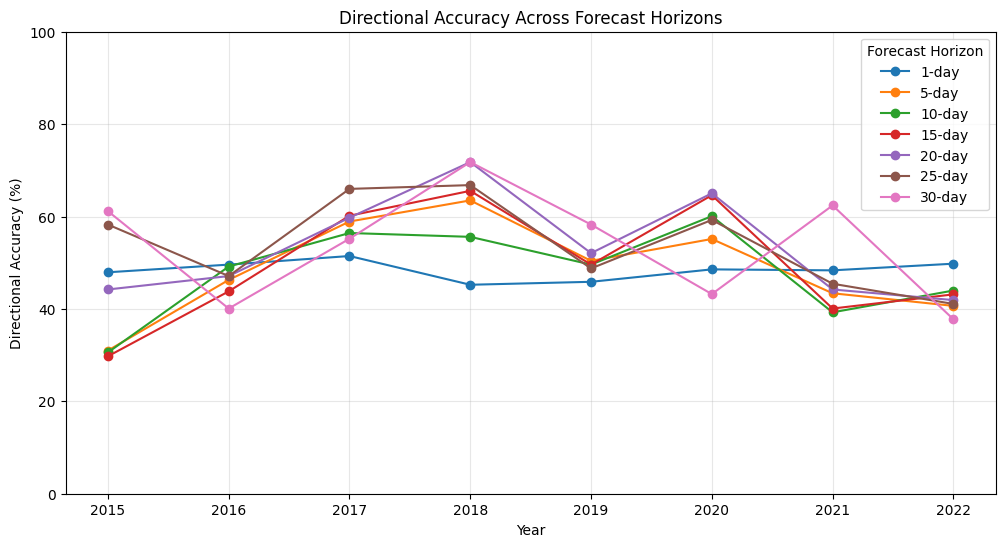

In [270]:
plot_directional_accuracy(metrics_combined_2)

In [274]:
def plot_spearman(df: pd.DataFrame):
    plt.figure(figsize=(12,6))

    for horizon in  df.index.levels[0]:
        series = df.loc[horizon]["spearman"]
        plt.plot(
            series.index, 
            series.values, 
            marker="o", linestyle="--", 
            label=f"{horizon}-day"
        )

    plt.title("Spearman Information Coefficient by Prediction Horizon")
    plt.xlabel("Year")
    plt.ylabel("Spearman Correlation")
    plt.axhline(0, color="black", linewidth=1)
    plt.grid(True, alpha=0.3)
    plt.legend(title="Forecast Horizon", bbox_to_anchor=(1.02,1), loc="upper left")
    plt.tight_layout()
    plt.show()

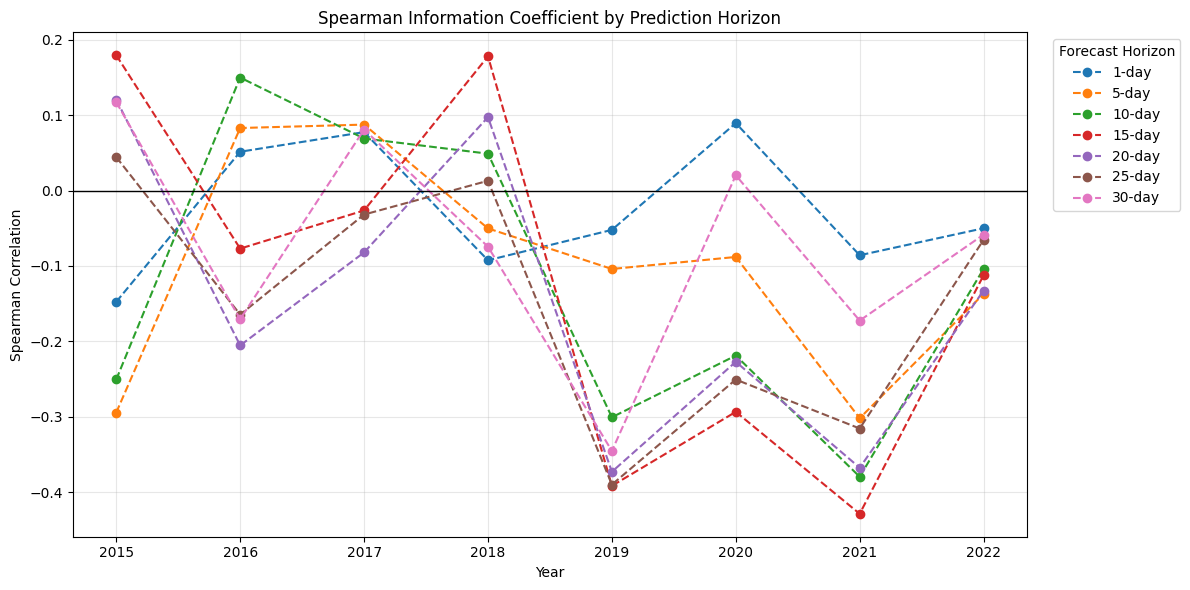

In [275]:
plot_spearman(metrics_combined_2)

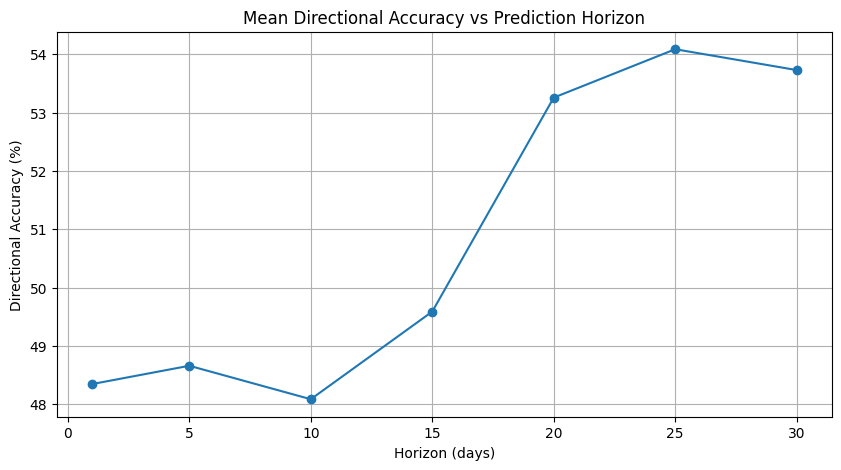

In [278]:
plt.figure(figsize=(10,5))
summary = metrics_combined_2.groupby(level=0)["directional_accuracy (%)"].mean()
plt.plot(summary.index, summary.values, marker="o")
plt.title("Mean Directional Accuracy vs Prediction Horizon")
plt.xlabel("Horizon (days)")
plt.ylabel("Directional Accuracy (%)")
plt.grid(True)
plt.show()

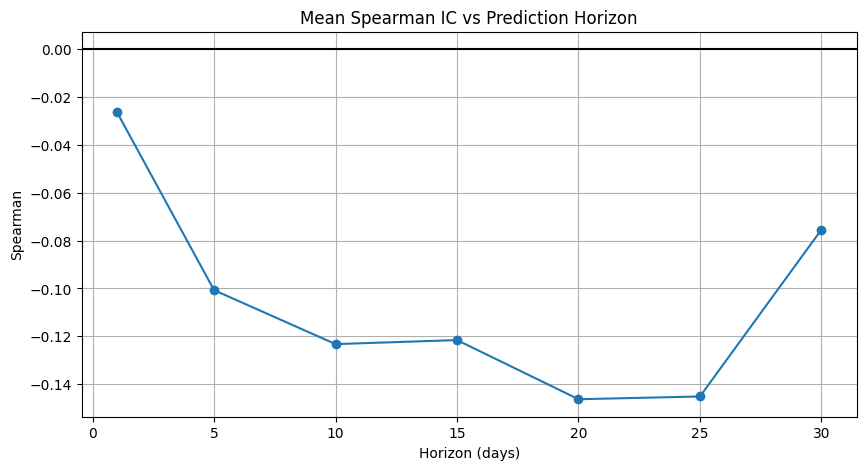

In [279]:
summary_ic = metrics_combined_2.groupby(level=0)["spearman"].mean()
plt.figure(figsize=(10,5))
plt.plot(summary_ic.index, summary_ic.values, marker="o")
plt.title("Mean Spearman IC vs Prediction Horizon")
plt.xlabel("Horizon (days)")
plt.ylabel("Spearman")
plt.axhline(0, color="black")
plt.grid(True)
plt.show()

#### Backtest

to find the best horizon as the baseline for neuroevolutionary adaptation.
we already determined that within the range of 15-30 days there is more learnable structure in the market which a evolutionary strategy can exploit. To further explore this solutiona space and ensure that the evolutionary search will start from a more optimal region of the search space we will implement a simple backtest on what was statistically the more promising band of the prediction horizons (15 - 30 days) according to the DA + IC examination.

#### NEAT implementation of NeuroEvolutionary network